In [61]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets.waymo.waymo_dataset_bc import WaymoDatasetBC as WaymoDataset
# from mtr.datasets.waymo.waymo_dataset import WaymoDataset

from tools.mtr_env import BatchMTREnv
from tools.mtr_inference import MTRInference
from tools.mtr_lightning import MTR_Lightning
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical, Independent

cfg = cfg_from_yaml_file('tools/cfgs/waymo/bc+10_percent_data_atten.yaml', cfg)
dataset = WaymoDataset(cfg.DATA_CONFIG, training=False)
env = BatchMTREnv(2, dataset)

model = MTR_Lightning(cfg)
model = model.load_from_checkpoint('output/bc_atten_2_freeze/epoch=1-step=6104.ckpt')
_ = model.cuda()


# Test with dataset

In [ ]:
output_mean = model.model.motion_decoder.output_mean
output_std = model.model.motion_decoder.output_std

In [ ]:
data = dataset[5]
data_batch = dataset.collate_batch([data])

In [ ]:
# model.train()
model.eval()
with torch.no_grad():
    loss, _, output = model.model(data_batch, True)
    center_gt_raw = output['input_dict']['center_gt'][..., :3]
    center_gt = output['input_dict']['center_gt'][...,None, :3].cuda()
    center_gt = (center_gt - output_mean) / output_std


In [ ]:

for pred_ctrls, pred_scores in output['pred_list']:
    i=-1
    print(pred_ctrls.shape)
    print(pred_ctrls[i, :, :3])
    print(pred_scores[i, :])
    # print(center_gt[i])
    # print(center_gt_raw[i])

In [ ]:

mode = model.model.motion_decoder.build_mode_distribution(pred_ctrls[...,:])
log_p = mode.log_prob(center_gt)
print(log_p)

In [ ]:
_, mode, gmm = model.model.motion_decoder.build_gmm_distribution(pred_ctrls, pred_scores)
log_p = -gmm.log_prob(center_gt.squeeze(1))
log_p

In [ ]:
mode, mix, gmm, sample = model.sample(data_batch)
print(sample)
print(center_gt_raw)

# Test in simulation

In [85]:
env.reset()

(34, 11, 10)
(46, 11, 10)


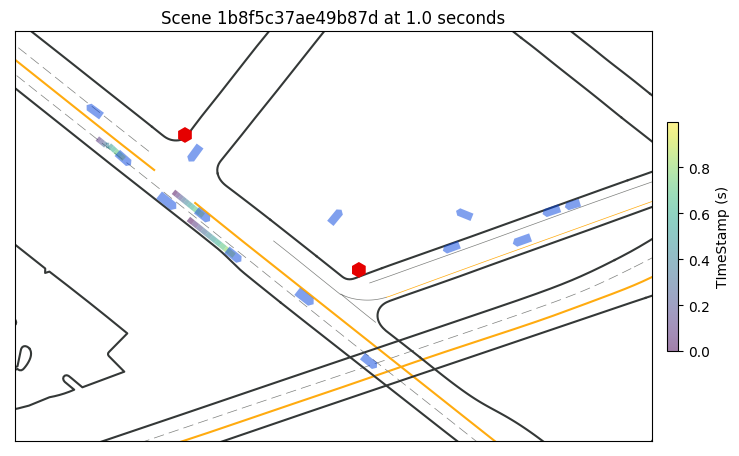

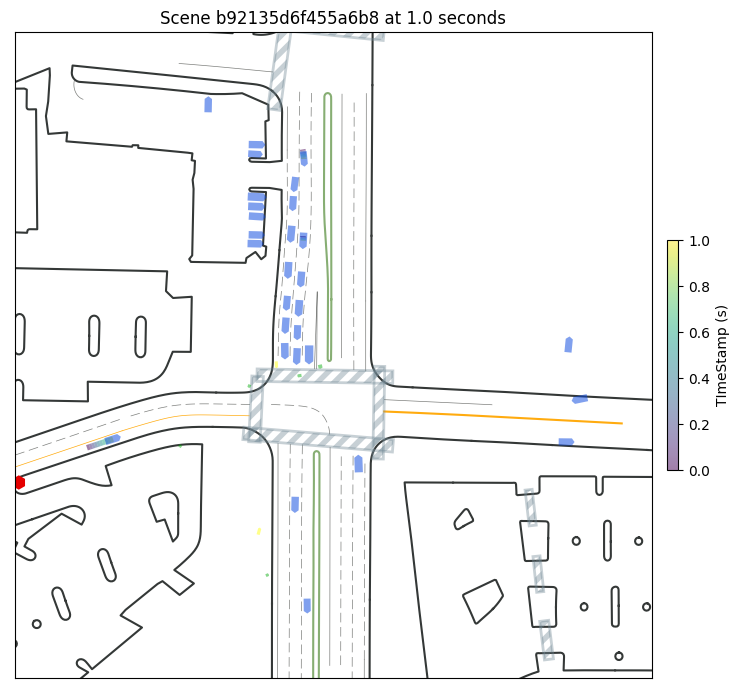

In [92]:
# Reset Time
for temp_env in env.envs_list:
    index = temp_env.index
    temp_env.reset(index)
env.visualize()
current_time_index = env.envs_list[0].current_time_index 

In [101]:
for _ in range(10):
    data_batch_sim = env.batch_sim_data
    action = model.sample(data_batch_sim)[-1]
    _ = env.step(data_batch_sim, action)
_ = env.visualize()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 for _ in range(10):                                                                          │
│   2 │   data_batch_sim = env.batch_sim_data                                                      │
│   3 │   action = model.sample(data_batch_sim)[-1]                                                │
│ ❱ 4 │   _ = env.step(data_batch_sim, action)                                                     │
│   5 _ = env.visualize()                                                                          │
│   6                                                                                              │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/tools/mtr_env.py:130 in step                                   │
│                                                                                                  │
│   127 │   │   for i, env in enumerate(self.envs_list):                                           │
│   128 │   │   │   env_mask = data['batch_env_idx'] == i                                          │
│   129 │   │   │   rel_se2_i = rel_se2[env_mask]                                                  │
│ ❱ 130 │   │   │   reset_bool[i] = env.step(rel_se2_i)                                            │
│   131 │   │   return reset_bool                                                                  │
│   132                                                                                            │
│   133 class MTREnv:                                                                              │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/tools/mtr_env.py:222 in step                                   │
│                                                                                                  │
│   219 │                                                                                          │
│   220 │   def step(self, rel_se2: np.ndarray):                                                   │
│   221 │   │   self.step_gt()                                                                     │
│ ❱ 222 │   │   self.step_control(rel_se2)                                                         │
│   223 │   │   self.current_time_index += 1                                                       │
│   224 │   │                                                                                      │
│   225 │   │   # self.scene_data = self.extract_scene_data()                                      │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/tools/mtr_env.py:250 in step_control                           │
│                                                                                                  │
│   247 │   │   T_next =np.einsum('...ij,...jk->...ik', T_cur, T_rel)                              │
│   248 │   │                                                                                      │
│   249 │   │   x_next, y_next, theta_next = self.SE2_to_state(T_next)                             │
│ ❱ 250 │   │   self.obj_trajs_sim[self.track_index_to_predict, self.current_time_index + 1, 0]    │
│   251 │   │   self.obj_trajs_sim[self.track_index_to_predict, self.current_time_index + 1, 1]    │
│   252 │   │                                                                                      │
│   253 │   │   self.obj_trajs_sim[self.track_index_to_predict, self.current_time_index + 1, 2]    │
╰────────────────────────────────────────────────────────────